## Step 0. Library import

In [1]:
#!pip install flopy

 1. importan las bibliotecas y módulos necesarios para realizar análisis y visualizaciones de datos relacionados con la modelación hidrogeológica utilizando MODFLOW con flopy.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.plot.styles import styles

## Step 1. Simulation parameters definition.

## Problema unidimensional de flujo utilizando CF tipo Dirichlet

**Descripción del problema**

1. Formulación de un problema unidimensional de flujo en medios porosos, considerando condiciones de frontera 
tipo Dirchlet en los extremos. 
2. La dimensión del dominio es de: (12)(0.1)(0.1)[cm] en cada una de las direcciones (X,Y,Z)
3. La conductividad hidráulica del sistema es: kxx = (0.01 [cm/s]) con Kyy=Kzz=Kxx.
4. Consideramos un período estrés de 120 [s], y un paso de tiempo
5. Tipo de capa confinada 
6. El sistema se discretizará en 122 columnas, 1 renglón y 1 capa.


$$  \nu=-\frac{k}{\mu}\left({grad} \; p+ \rho {g}\right) = K \nabla h$$

$$ \frac{\partial (\rho\phi)}{\partial t} + \mbox{div}(\rho{\nu}) 
=\rho\widehat{q}
$$

$$ \begin{matrix} \begin{array}{l}
p(x_0,0) = p_0, &  p(x_{\infty},0) = p_{1} \cr
\end{array}\end{matrix}
$$

## Glosario de términos
\begin{matrix} \begin{array}{l}
\nu[LT^{-1}]:   \mbox{es la velocidad promedio del agua a través del medio poroso,} \cr
{k}[L^2]:  \mbox{es el tensor de permeabilidad intrínsico} \cr
{K}[LT^{-1}]:  \mbox{Conductividad hidráulica} \cr
p[ML^{-1}T^{-2}]:  \mbox{la presión del fluido}\cr
\rho[ML^{-3}]:  \mbox{la densidad de masa del fluido}  \cr
{g}[LT^{-2}]: \mbox{el vector aceleración de la gravedad} \cr
\widehat{q}[T^{-1}]: \mbox{es la razón de flujo volumétrico del fluido} \cr 
\mbox{fuentes (positivas) y sumideros (negativos) de fluidos, } \cr
t[T] = \mbox{tiempo, } \cr
\phi[] = \mbox{porosidad del medio} \cr
\mu[ML^{−1}T^{−1}] = \mbox{viscosidad dinámica del fluído.}
\end{array}\end{matrix}

## Unidades del modelo
Todos los parámetros físicos, espaciales y temporales del modelo, deben ser consistentes con estas unidades
1.  **Parámetros del modelo**
2. **nper**: número de periodos estres en que se divide el tiempo total de simulación
3. en cada periodo estres, los parámetros fisicos, CF, gasto de pozos,etc.  permanecen constantes
4. En este caso se considera un período estrés, un paso de tiempo y un tiempo total de simulación de 120 [s].
5. Tipo de capa confinada 
6. El sistema se discretizará en 122 columnas, 1 renglón y 1 capa.
7. system_length: En este caso se tiene "un dominio 1D", solo se especifica su longitud.
   Sin embargo el dominio tiene un ancho en la dirección de las columnas y los renglones 
   delc=0.1cm y delr=0.1cm y también tiene un espesor top-botm= 1cm
8.  Nótese que las unidades deben ser consistentes a la hora de definir los parámetros

In [3]:
# Model units
length_units = "centimeters"
time_units = "seconds"

# Model parameters

## Discretization
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 122  # Number of columns
system_length = 12.0  # Length of system ($cm$)
delr = 0.1  # Column width ($cm$)
delc = 0.1  # Row width ($cm$)
top = 1.0  # Top of the model ($cm$)
botm = 0  # Layer bottom elevation ($cm$)

## Physical parameters
specific_discharge = 0.1  # Specific discharge ($cm s^{-1}$)
hydraulic_conductivity = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
porosity = 0.1  # Porosity of mobile domain (unitless)
source_concentration = 1.0  # Source concentration (unitless)
initial_concentration = 0.0  # Initial concentration (unitless)
total_time = 120.0  # Simulation time ($s$)

## Step 2. Path to MODFLOW6 and simulation name

1. ws = os.getcwd(): Variable que contiene la ruta asociada del Directorio de trabajo.
2. mf6_exe = "mf6.exe": En Python se asigna la variable 'mf6_exe' al ejecutable "mf6.exe".
3. name = 'model': La variable 'name' contiene el nombre asociado a la simulación que se está trabajando.

In [4]:
ws = os.getcwd() # Devuelve una cadena Unicode conteniendo el directorio de trabajo actual. 
mf6_exe = "mf6.exe" # Ruta del ejecutable,en este caso el propio directorio de trabajo 
name = 'model' # Nombre de la simulación a trabajar

print(' Ruta hacia el ejecutable de MODFLOW 6 : {} '.format(mf6_exe))
print(' Ruta actual : {}'.format(ws))
print(' Nombre de esta simulación: {}'.format(name))

 Ruta hacia el ejecutable de MODFLOW 6 : mf6.exe 
 Ruta actual : C:\Users\NRBRT\clone\WMA\notebooks\test1D\flujo_1D
 Nombre de esta simulación: model


## Step 3. Simulation object

1. **sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=mf6_exe)**:
2. Configura una simulación de MODFLOW 6 con el nombre de la simulación, el directorio de trabajo y el archivo ejecutable especificados.
3. **Los argumentos son: el nombre de la simulación, el directorio de trabajo, el ejecutable a utilizar.**
4. **Por default**: (sim_name='sim', version='mf6', exe_name='mf6.exe', sim_ws='.',verbosity_level=1,
    continue_=None, nocheck=None, memory_print_option=None, write_headers=True)    
5. verbosity_level=0, no hay información de salida 
6. continue_: Indica si la simulación debe continuar desde una simulación anterior. Si se establece en True, la simulación continuará desde donde se detuvo anteriormente.
7. **nocheck**: Controla si se realizan verificaciones durante la ejecución del modelo. Establecer en True desactivará las verificaciones
8. **memory_print_option**: Opción para imprimir información de uso de memoria durante la ejecución.
9. **write_headers**: Cuando write_headers=true flopy escribe un encabezado en cada archivo de paquete indicando que
     fue creado por flopy.

In [5]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=mf6_exe)
print(sim)

sim_name = model
sim_path = C:\Users\NRBRT\clone\WMA\notebooks\test1D\flujo_1D
exe_name = mf6.exe

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = model





## Step 4. Time discretization object

<center>
<img src="../figures/timestep.png" width=500px>
</center>
  
The length of a time step is calculated by multiplying the length of the previous time step by TSMULT. 
The length of the first time step, $\Delta t_1$, is related to PERLEN, NSTP, and TSMULT by the relation:
$$
\Delta t_1= \frac{\text{PERLEN}}{\text{NSTP}} \;\; \text{para} \;\; \text{TSMULT} = 1
$$

$$
\Delta t_1= \text{PERLEN} \frac{\text{TSMULT} - 1}{\text{TSMULT}^\text{nstp}-1} \;\; \text{para} \;\; \text{TSMULT} \neq 1
$$

The length of each successive time step is computed as

$$
\Delta t = \Delta t_{old} \text{TSMULT}
$$

where:
* `perlen` (double) is the length of a stress period.
* `nstp` (integer) is the number of time steps in a stress period.
* `tsmult` (double) is the multiplier for the length of successive time steps.
  
Véase: Hughes, J.D., Langevin, C.D., and Banta, E.R., 2017, *Documentation for the MODFLOW 6 framework: U.S. Geological Survey Techniques and Methods*, book 6, chap. A57, 40 p., https://doi.org/10.3133/tm6A57. **Timing Module, pp 10,12**.

1. **tdis_ds = ((total_time, 1, 1.0),)** define un solo período de tiempo en la simulación, con una duración total especificada, un solo paso de tiempo y posiblemente un factor de multiplicación para ajustar el paso de tiempo.
2. **total_time**: Es el tiempo total del período de simulación que se definió en **Step 1**
3. **1**: Indica el número de pasos de tiempo en este período
4. **1.0**: Es el factor de aumento del paso de tiempo para este período.
5. Si no se da ningún argumento, el constructor devuelve una tupla vacía.

In [6]:
tdis_ds = ((total_time, 1, 1.0),) # perlen, nstp, tsmult

1. **flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)**
2. Configura la discretización temporal para una simulación de MODFLOW 6 "sim", especificando el número de períodos "nper", los datos de período "tdis_ds" y las unidades de tiempo "time_units".
1. **sim**: Es la instancia de la simulación a la que se asocia este objeto ModflowTdis definido en **Step 3**.
2. **nper**: Número de períodos de tiempo en la simulación, en este caso nper=1 .
3. **perioddata**: Especifica la información detallada sobre los períodos de tiempo. En este caso, tdis_ds es una variable que contiene esta información. Esta variable generalmente consiste en una tupla de tuplas, donde cada tupla interna contiene tres valores: el tiempo total del período, el número de pasos de tiempo y el factor de aumento del paso de tiempo como se indicó arriba.
4. **time_units**: Especifica las unidades de tiempo utilizadas en el modelo

**Por default**: flopy.mf6.ModflowTdis(
    **simulation**,
    loading_package=False, (indica si el paquete TDIS está activado o no.)
    **time_units=None**,
    start_date_time=None,
    ats_filerecord=None,
    **nper=1**,
    **perioddata=((1.0, 1, 1.0),)**,
    filename=None,
    pname=None,
    parent_file=None,
)

In [7]:
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

package_name = model.tdis
filename = model.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = model

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 1, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', '<i4'), ('tsmult', '<f8')]))



## Step 5. IMS object (solution calculation)

1. **ims = flopy.mf6.ModflowIms(sim)**
2. configura varios aspectos del solucionador IMS para la simulación de MODFLOW 6, proporcionando flexibilidad en la configuración de la convergencia y otros aspectos del modelo.
3. **sim**: El objeto de simulación de MODFLOW 6 al que se aplicará la configuración del solucionador IMS.
4. Por default: ims = flopy.mf6.ModflowIms(
    simulation,
    loading_package=False,
    print_option=None,
    complexity=None,
    csv_output_filerecord=None,
    csv_outer_output_filerecord=None,
    csv_inner_output_filerecord=None,
    no_ptcrecord=None,"Registro para controlar el precondicionador. Por defecto, es None"
    ats_outer_maximum_fraction=None,
    outer_hclose=None,
    outer_dvclose=None,
    outer_rclosebnd=None,
    outer_maximum=None,
    under_relaxation=None,
    under_relaxation_gamma=None,
    under_relaxation_theta=None,
    under_relaxation_kappa=None,
    under_relaxation_momentum=None,
    backtracking_number=None,
    backtracking_tolerance=None,
    backtracking_reduction_factor=None,
    backtracking_residual_limit=None,
    inner_maximum=None,
    inner_hclose=None,
    inner_dvclose=None,
    rcloserecord=None,
    linear_acceleration=None,
    relaxation_factor=None,
    preconditioner_levels=None,
    preconditioner_drop_tolerance=None,
    number_orthogonalizations=None,
    scaling_method=None,
    reordering_method=None,
    filename=None,
    pname=None,
    parent_file=None,
)


In [8]:
ims = flopy.mf6.ModflowIms(sim)
print(ims)

package_name = ims_-1
filename = model.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = model




## Step 6. GWF model object (flow)

1. **gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)**
2.  crea un modelo de flujo en la simulación de MODFLOW 6, especificando su nombre y configurando la opción para guardar los flujos calculados durante la simulación
3. **gwf** se asocia con la simulación sim y se le asigna el nombre de modelo especificado por la variable "name". 
4. **save_flows=True**, indica que se guardarán los flujos calculados durante la simulación. 
5. Por default: flopy.mf6.ModflowGwf(
    simulation,
    modelname='model',
    model_nam_file=None,
    version='mf6',
    exe_name='mf6.exe',
    model_rel_path='.',
    list=None,
    print_input=None,
    print_flows=None,
    save_flows=None,
    newtonoptions=None,
    packages=None,
    **kwargs,
)

In [9]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
print(gwf)

name = model
model_type = gwf6
version = mf6
model_relative_path = .




## Step 7. Space discretization object

1. **dis = flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,
    botm=botm,)**
2. Configura los datos de discretización espacial para el modelo de flujo en la simulación de MODFLOW 6, incluyendo el número de capas, filas y columnas, así como las dimensiones y elevaciones de cada celda del modelo. 
3. El objeto **dis** se asocia con el modelo de flujo **gwf** y se especifican diversos parámetros de discretización, como:
4. **length_units** las unidades de longitud definidas, 
5. **nlay** el número de capas, **nrow** el número de renglones y **ncol** el número de columnas, 
6. **delr** los tamaños de celda horizontal  y **delc** vertical , 
7. **top** las elevaciones de la superficie superior  y **botm** los fondos de las capas . 
8. Estos parámetros definen la estructura espacial del modelo de flujo.
9. Por default:
   flopy.mf6.ModflowGwfdis(
    model,
    loading_package=False, 
    length_units=None,
    nogrb=None,
    xorigin=None,
    yorigin=None,
    angrot=None,
    nlay=1,
    nrow=2,
    ncol=2,
    delr=1.0,
    delc=1.0,
    top=1.0,
    botm=0.0,
    idomain=None,
    filename=None,
    pname=None,
    parent_file=None,
)

In [10]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              length_units=length_units,
                              nlay=nlay,
                              nrow=nrow,
                              ncol=ncol,
                              delr=delr,
                              delc=delc,
                              top=top,
                              botm=botm,
)
print(dis)

package_name = dis
filename = model.dis
package_type = dis
model_or_simulation_package = model
model_name = model

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(122)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0}





## Step 8. Initial conditions object

1. **ic = flopy.mf6.ModflowGwfic(gwf, strt=1.0)**
2. Configura las condiciones iniciales para el modelo de flujo en la simulación de MODFLOW 6, definiendo el valor inicial de la carga hidráulica para todas las celdas del modelo.
3. **gwf**: Objeto de modelo MODFLOW 6 al que se asociará el paquete de condiciones iniciales.
4. **strt=1.0**: Valor de la elevación inicial del nivel freático para todas las celdas del modelo. Por defecto, es 1.0.
5. Por default:
flopy.mf6.ModflowGwfic(
    model,
    loading_package=False,
    strt=1.0,
    filename=None,
    pname=None,
    parent_file=None,
)

In [11]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=1.0)
print(ic)

package_name = ic
filename = model.ic
package_type = ic
model_or_simulation_package = model
model_name = model

Block griddata
--------------------
strt
{constant 1.0}





## Step 9. Node Property Flow (NPF6) Package

1. **npf = flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,save_saturation=True,
   icelltype=0, k=hydraulic_conductivity,)** 
2. Configura los datos de propiedades de flujo no confinado para el modelo de flujo en la simulación de MODFLOW 6, incluyendo la configuración para guardar caudales específicos y saturaciones, el tipo de celda y la conductividad hidráulica del medio poroso.

3. **gwf**: El modelo MODFLOW 6 al que se asociará el paquete de parámetros de flujo.
4. **save_specific_discharge=True**: Indica que se deben guardar las descargas específicas en cada celda del modelo
5. **save_saturation=True**: Indica si se deben guardar las saturaciones de agua en cada celda del modelo
6. **icelltype=0**: Especifica el tipo de celda. 0 para celdas confinadas y 1 para celdas no confinadas.
7. **k=hydraulic_conductivity**: Un arreglo numpy que define la conductividad hidráulica en cada celda del modelo. Debe tener la misma forma que el número total de celdas en el modelo
8. Por default:
flopy.mf6.ModflowGwfnpf(
    model,
    loading_package=False,
    save_flows=None,
    alternative_cell_averaging=None,
    thickstrt=None,
    cvoptions=None,
    perched=None,
    rewet_record=None,
    xt3doptions=None,
    save_specific_discharge=None,
    save_saturation=None,
    k22overk=None,
    k33overk=None,
    tvk_filerecord=None,
    icelltype=0, "Celda no confinada:"
    k=1.0,
    k22=None,
    k33=None,
    angle1=None,
    angle2=None,
    angle3=None,
    wetdry=None, "Opción para las celdas secas. Por defecto, es None."
    filename=None,
    pname=None,
    parent_file=None,
)

2. save_specific_discharge=True: Indica que se guardará el flujo específico. 

In [12]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              save_specific_discharge=True,
                              save_saturation=True,
                              icelltype=0,
                              k=hydraulic_conductivity,
)
print(npf)

package_name = npf
filename = model.npf
package_type = npf
model_or_simulation_package = model
model_name = model

Block options
--------------------
save_specific_discharge
{internal}
(True)

save_saturation
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.01}





## Step 10. Discharge object 

1. **chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])**
2. Configura las condiciones de carga constante para el modelo de flujo en la simulación de MODFLOW 6, donde se establece una carga constante de 1.0 en la celda especificada para el primer período de estrés.
3. Estas condiciones permiten la interacción entre el flujo de agua subterránea y las estructuras superficiales, como pozos, ríos o cuerpos de agua.
4. En este caso:
5. **gwf**: El modelo MODFLOW 6 al que se asociará el paquete de condiciones de carga constante.
6. **stress_period_data**: Una lista de listas que define los datos de período de estrés para las condiciones de carga constante. Cada sublista contiene una tupla que representa la ubicación (k, i, j) de la celda y el valor de la carga constante. 
7. **Por ejemplo, [(0, 0, ncol - 1), 1.0]** establece una carga constante de 1.0 en la celda ubicada en la capa 0, fila 0 y columna ncol - 1.
8. Por default:
flopy.mf6.ModflowGwfchd(
    model,
    loading_package=False,
    auxiliary=None,
    auxmultname=None,
    boundnames=None,
    print_input=None,
    print_flows=None,
    save_flows=None,
    timeseries=None,
    observations=None,
    maxbound=None,
    stress_period_data=None,
    filename=None,
    pname=None,
    parent_file=None,
)

In [13]:
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]]) 
print(chd)

package_name = chd_0
filename = model.chd
package_type = chd
model_or_simulation_package = model
model_name = model

Block period
--------------------
stress_period_data
{internal}
([((0, 0, 121), 1.)])





## Step 11. Wells object

1. **wel_spd = {0: [ [(0, 0, 0), specific_discharge * delc * delr * top, source_concentration]] }**
2. Define los datos de flujo de pozo para un modelo de flujo en la simulación de MODFLOW 6, especificando la ubicación, la tasa de flujo y la concentración para cada pozo en el primer período de estrés.
3. **wel_spd** es un diccionario que contiene datos de asignación de pozos para un paquete de pozos (flopy.mf6.ModflowGwfwel) en un modelo MODFLOW 6
4. **wel_spd** define un pozo para el modelo MODFLOW 6 con información sobre su ubicación, caudal específico y concentración de la fuente.
5. **wel_spd** tiene claves que representan los períodos de estrés. En este caso, hay un único período de estrés con la clave 0
6. Cada valor asociado a una clave de período de estrés es una lista. En este caso, la lista contiene un solo elemento.
7. Dentro de esta lista, hay otra lista que contiene tres elementos:
8. Una tupla que representa la ubicación del pozo (k, i, j). Por ejemplo, (0, 0, 0) indica la ubicación del pozo en la capa 0, fila 0 y columna 0.
9. El segundo elemento es el caudal específico del pozo, que se calcula como el producto del caudal específico (specific_discharge) y el área de la celda del pozo, que se calcula como el producto de los tamaños de las celdas delc y delr, y la elevación superior de la celda (top).
10. El tercer elemento es la concentración de la fuente asociada al pozo.

1. **wel = flopy.mf6.ModflowGwfwel(gwf,stress_period_data=wel_spd,pname="WEL-1",auxiliary=["CONCENTRATION"],)**
2. Configura y añade un paquete de flujo de pozo al modelo de flujo en la simulación de MODFLOW 6, especificando los datos de los períodos de estrés, el nombre del paquete y las variables auxiliares asociadas.
3. **gwf**: Es el modelo de flujo (flopy.mf6.ModflowGwf) al que se asocia este paquete de pozos.
4. **stress_period_data=wel_spd**: Es un diccionario que contiene datos de asignación de pozos para cada período de estrés.  Cada clave del diccionario representa un período de estrés, y los valores asociados son listas que contienen la información de cada pozo para ese período de estrés. La estructura de estos datos se describe en la descripción anterior del diccionario wel_spd.
6. **pname="WEL-1"**: Es el nombre del paquete. En este caso, "WEL-1".
7. **auxiliary=["CONCENTRATION"]**: Es una lista opcional de nombres de variables auxiliares asociadas con este paquete de pozos. En este caso, hay una variable auxiliar llamada "CONCENTRATION".

In [14]:
wel_spd = {
    0: [ [(0, 0, 0),
          specific_discharge * delc * delr * top,
          source_concentration]
       ]
}

wel = flopy.mf6.ModflowGwfwel(gwf,
                              stress_period_data=wel_spd,
                              pname="WEL-1",
                              auxiliary=["CONCENTRATION"],
)

print(wel)

package_name = wel-1
filename = model.wel
package_type = wel
model_or_simulation_package = model
model_name = model

Block options
--------------------
auxiliary
{internal}
([('auxiliary', 'CONCENTRATION')])


Block period
--------------------
stress_period_data
{internal}
([((0, 0, 0), 0.001, 1.)])





## Step 12. Output object

1. **head_filerecord = f"{name}.hds"**  representa el nombre de un archivo  (hds) asociado al modelo
2. **budget_filerecord = f"{name}.bud"** representa el nombre de un archivo de balance (bud) asociado al modelo
3. **oc = flopy.mf6.ModflowGwfoc(gwf, head_filerecord=head_filerecord, budget_filerecord=budget_filerecord, saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],)**
3. Configura un paquete de control de salida para el modelo de flujo de agua subterránea, definiendo los archivos donde se guardarán las cargas de agua y los datos de balance, así como qué datos se guardarán durante la simulación.
4. **gwf**: Es la instancia del modelo de flujo de agua subterránea (Gwf) al que se asocia el paquete de control de salida.
5. **head_filerecord=head_filerecord**: Es el nombre del archivo donde se guardarán los resultados de las cargas (HEAD). 
6. El valor de esta cadena se ha definido previamente como f"{name}.hds".
7. **budget_filerecord=budget_filerecord**: Es el nombre del archivo donde se guardarán los resultados del balance (BUDGET). El valor de esta cadena se ha definido previamente como f"{name}.bud".
8. **saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")]**: indica que se guardarán todos los datos de cargas (HEAD) y todos los datos de balance (BUDGET) durante cada paso de tiempo de la simulación.
9. Por default: flopy.mf6.ModflowGwfoc(
    model,
    loading_package=False,
    budget_filerecord=None,
    budgetcsv_filerecord=None,
    head_filerecord=None,
    headprintrecord=None,
    saverecord=None,
    printrecord=None,
    filename=None,
    pname=None,
    parent_file=None,
)

In [15]:
head_filerecord = f"{name}.hds"
budget_filerecord = f"{name}.bud"
oc = flopy.mf6.ModflowGwfoc(gwf,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print(oc)

package_name = oc
filename = model.oc
package_type = oc
model_or_simulation_package = model
model_name = model

Block options
--------------------
budget_filerecord
{internal}
([('model.bud',)])

head_filerecord
{internal}
([('model.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
None




## Step 13. Write Input files.

1. El método **write_simulation()** se utiliza para escribir todos los archivos de entrada necesarios para ejecutar la simulación de MODFLOW 6 en el directorio de trabajo especificado por **sim_ws** durante la inicialización de la simulación.

In [16]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


## Step 14. Run simulation

In [17]:
sim.run_simulation()

FloPy is using the following executable to run the model: .\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held

(True, [])

## Step 15. Postprocessing

In [18]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(os.path.join(ws, head_filerecord)).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(os.path.join(ws, budget_filerecord),
                                  precision='double')
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [19]:
print(head.shape, '\n', head[0,0])

(1, 1, 122) 
 [13.1 13.  12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1 12.  11.9 11.8
 11.7 11.6 11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7 10.6 10.5 10.4
 10.3 10.2 10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3  9.2  9.1  9.
  8.9  8.8  8.7  8.6  8.5  8.4  8.3  8.2  8.1  8.   7.9  7.8  7.7  7.6
  7.5  7.4  7.3  7.2  7.1  7.   6.9  6.8  6.7  6.6  6.5  6.4  6.3  6.2
  6.1  6.   5.9  5.8  5.7  5.6  5.5  5.4  5.3  5.2  5.1  5.   4.9  4.8
  4.7  4.6  4.5  4.4  4.3  4.2  4.1  4.   3.9  3.8  3.7  3.6  3.5  3.4
  3.3  3.2  3.1  3.   2.9  2.8  2.7  2.6  2.5  2.4  2.3  2.2  2.1  2.
  1.9  1.8  1.7  1.6  1.5  1.4  1.3  1.2  1.1  1. ]


In [20]:
print(qx.shape, '\n', qx)

(1, 1, 122) 
 [[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


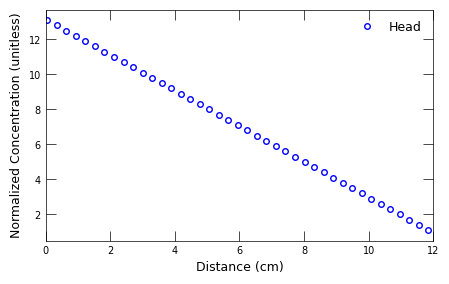

In [21]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'

    x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol)
    plt.figure(figsize=(5,3))
    plt.plot(x[::3], head[0, 0][::3], marker="o", ls ="none", mec="blue", mfc="none", markersize="4", label = 'Head')
    plt.xlim(0, system_length)
    plt.xlabel("Distance (cm)")
    plt.ylabel("Normalized Concentration (unitless)")
    plt.legend()
    plt.show()